In [12]:
import torch
import torch.nn as nn
import torchvision
import torchinfo
from torchvision import transforms

from engine import  train
from data_setup import create_dataloaders
from helper_functions import plot_loss_curves
from utils import save_model

import PIL
from pathlib import Path
import os
from timeit import default_timer as Timer
from typing import List
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#WHAT TO DO?
#IN THIS NOTEBOOK, I'LL BE USING efficient b0,b1 and b2. FINE TUNE THEM AND COMPARE THE RESULTS

#1. IMPORT REQUIRED LIBRARIES, FUNCTIONS
#2. 


In [3]:
data_path = Path("data")
twenty_percent_path = data_path / "pizza_steak_sushi_20_percent"

train_path = twenty_percent_path / "train"
test_path = twenty_percent_path / "test"

pizza_list = ["sicilian_pizza.jpg", "pizza2.jpg", "pizza3.jpg"]
pizza_paths = [Path(data_path / pizza) for pizza in pizza_list]

In [4]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
TRANSFORM = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir= train_path,
    test_dir= test_path,
    transform=TRANSFORM,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS    
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e3b5f72fd0>,
 ['pizza', 'steak', 'sushi'])

In [6]:
weights_b0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights_b1 = torchvision.models.EfficientNet_B1_Weights.DEFAULT
weights_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT

In [7]:
model_b0 = torchvision.models.efficientnet_b0(weights=weights_b0)
model_b1 = torchvision.models.efficientnet_b1(weights=weights_b1)
model_b2 = torchvision.models.efficientnet_b2(weights=weights_b2)

model_list = [model_b0, model_b1, model_b2]

In [8]:
#TO FINE-TUNE OUR PRE-TRAINED MODELS, LET'S WRITE A FUNCTION

def finetune_efficientnet_model(model: nn.Module,
                                train_dataloader: torch.utils.data.DataLoader = train_dataloader,
                                test_dataloader: torch.utils.data.DataLoader = test_dataloader,
                                class_number: int = len(class_names),
                                lr: float = 0.003,
                                epochs: int = 10,
                                device: torch.device = DEVICE
                                ):
    
    """
    Fine-tunes a pre-trained EfficientNet model by:
    - Freezing its feature extractor layers,
    - Replacing its classification head with a custom head for a new classification task,
    - Training the new head using the given data.

    Parameters:
    -----------
    model : torch.nn.Module
        A pre-trained EfficientNet model (e.g., torchvision.models.efficientnet_b0()).
    train_dataloader : torch.utils.data.DataLoader
        Dataloader containing training images and labels.
    test_dataloader : torch.utils.data.DataLoader
        Dataloader containing test images and labels.
    class_number : int
        Number of output classes for the new classification task.
    lr : float
        Learning rate for the optimizer (default=0.003).
    epochs : int
        Number of epochs to train the model (default=10).
    device : torch.device
        Device to use for training (e.g., "cuda" or "cpu").

    Returns:
    --------
    model : torch.nn.Module
        The fine-tuned model with a custom classification head.
    model_results : Dict[str, List[float]]
        Dictionary containing loss and accuracy values for each epoch.
    train_test_time : float
        Total time in seconds taken to train and evaluate the model.
    """


    #FREEZE LAYERS
    for param in model.features.parameters():
        param.requires_grad = False
    
    #REPLACE CLASSIFICATION BLOCK WITH OUR OWN BLOCK
    in_features = model.classifier[1].in_features #DIFFERENT MODEL DOFFERENT in_feature
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=in_features, out_features= class_number, bias=True)
    )

    #AFTER FORMING OUR MODEL, IT'S TIME TO TRAIN OUR MODEL. 
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr) #Thanks to AI :)

    start_time = Timer()
    model_results = train(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader= test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=epochs,
        device= device
    )
    end_time = Timer()
    
    train_test_time = end_time - start_time
    return model, model_results, train_test_time

In [9]:
def pred_and_plot_random_images(model_list: List[nn.Module] = model_list,
                                dataloader: torch.utils.data.DataLoader = test_dataloader,
                                k: int = 3,
                                device: torch.device = DEVICE

):
    sample_list = []
    label_list = []

    if k > 5:
        print("[INFO] To visualize properly k has a maximum value of 5. K is set to 5")
        k = 5

    model_count = len(model_list)
    fig, axs = plt.subplots(k, model_count + 1, figsize=(4*(model_count+1), 4*k))

    random_indices = random.sample(range(len(dataloader.dataset)), k)
    samples = [dataloader.dataset[i] for i in random_indices]

    for row, (image, true_label) in enumerate(samples):
        axs[row, 0].imshow(image.permute(1, 2, 0))
        axs[row, 0].set_title(f"Ground Truth: {class_names[true_label]}")
        axs[row, 0].axis("off")

        for col, model in enumerate(model_list):
            model.eval()
            model.to(device)

            with torch.inference_mode():
                image_batch = image.unsqueeze(0).to(device)
                pred_logits = model(image_batch)
                pred_probs = torch.softmax(pred_logits, dim=1)
                pred_label = torch.argmax(pred_probs, dim=1).item()
                pred_conf = pred_probs[0][pred_label].item()

            axs[row, col+1].imshow(image.permute(1, 2, 0))
            axs[row, col+1].set_title(f"{type(model).__name__}\nPred: {class_names[pred_label]}\nConf: {pred_conf:.2f}")
            axs[row, col+1].axis("off")
    
    plt.tight_layout()
    plt.show()



In [10]:
model_b0, model_b0_results, model_b0_time = finetune_efficientnet_model(model=model_b0)
model_b1, model_b1_results, model_b1_time = finetune_efficientnet_model(model=model_b1)
model_b2, model_b2_results, model_b2_time = finetune_efficientnet_model(model=model_b2)

 10%|█         | 1/10 [00:17<02:40, 17.89s/it]

Epoch: 1 | train_loss: 0.7747 | train_acc: 0.7021 | test_loss: 0.3517 | test_acc: 0.9284


 20%|██        | 2/10 [00:34<02:16, 17.04s/it]

Epoch: 2 | train_loss: 0.4812 | train_acc: 0.7979 | test_loss: 0.2836 | test_acc: 0.9165


 30%|███       | 3/10 [00:50<01:57, 16.79s/it]

Epoch: 3 | train_loss: 0.4059 | train_acc: 0.8625 | test_loss: 0.2621 | test_acc: 0.9318


 40%|████      | 4/10 [01:07<01:40, 16.73s/it]

Epoch: 4 | train_loss: 0.3598 | train_acc: 0.8667 | test_loss: 0.2504 | test_acc: 0.9409


 50%|█████     | 5/10 [01:23<01:23, 16.60s/it]

Epoch: 5 | train_loss: 0.2764 | train_acc: 0.9167 | test_loss: 0.2431 | test_acc: 0.9165


 60%|██████    | 6/10 [01:40<01:06, 16.58s/it]

Epoch: 6 | train_loss: 0.2285 | train_acc: 0.9187 | test_loss: 0.2403 | test_acc: 0.9227


 70%|███████   | 7/10 [01:56<00:49, 16.52s/it]

Epoch: 7 | train_loss: 0.2495 | train_acc: 0.9167 | test_loss: 0.2540 | test_acc: 0.9199


 80%|████████  | 8/10 [02:13<00:33, 16.52s/it]

Epoch: 8 | train_loss: 0.2800 | train_acc: 0.9146 | test_loss: 0.2093 | test_acc: 0.9256


 90%|█████████ | 9/10 [02:29<00:16, 16.50s/it]

Epoch: 9 | train_loss: 0.2637 | train_acc: 0.9104 | test_loss: 0.2550 | test_acc: 0.9199


100%|██████████| 10/10 [02:46<00:00, 16.64s/it]


Epoch: 10 | train_loss: 0.2293 | train_acc: 0.9271 | test_loss: 0.2315 | test_acc: 0.9227


 10%|█         | 1/10 [00:16<02:28, 16.54s/it]

Epoch: 1 | train_loss: 0.8479 | train_acc: 0.7000 | test_loss: 0.5562 | test_acc: 0.9199


 20%|██        | 2/10 [00:33<02:12, 16.54s/it]

Epoch: 2 | train_loss: 0.4932 | train_acc: 0.8958 | test_loss: 0.3731 | test_acc: 0.9284


 30%|███       | 3/10 [00:49<01:56, 16.66s/it]

Epoch: 3 | train_loss: 0.3615 | train_acc: 0.9333 | test_loss: 0.3377 | test_acc: 0.9136


 40%|████      | 4/10 [01:06<01:39, 16.65s/it]

Epoch: 4 | train_loss: 0.3308 | train_acc: 0.9229 | test_loss: 0.2687 | test_acc: 0.9409


 50%|█████     | 5/10 [01:22<01:22, 16.56s/it]

Epoch: 5 | train_loss: 0.2925 | train_acc: 0.9208 | test_loss: 0.2566 | test_acc: 0.9256


 60%|██████    | 6/10 [01:39<01:06, 16.59s/it]

Epoch: 6 | train_loss: 0.2752 | train_acc: 0.9167 | test_loss: 0.2437 | test_acc: 0.9347


 70%|███████   | 7/10 [01:56<00:49, 16.62s/it]

Epoch: 7 | train_loss: 0.2332 | train_acc: 0.9062 | test_loss: 0.2439 | test_acc: 0.9290


 80%|████████  | 8/10 [02:13<00:33, 16.68s/it]

Epoch: 8 | train_loss: 0.2134 | train_acc: 0.9604 | test_loss: 0.2313 | test_acc: 0.9409


 90%|█████████ | 9/10 [02:29<00:16, 16.73s/it]

Epoch: 9 | train_loss: 0.1897 | train_acc: 0.9563 | test_loss: 0.2273 | test_acc: 0.9318


100%|██████████| 10/10 [02:47<00:00, 16.72s/it]


Epoch: 10 | train_loss: 0.1941 | train_acc: 0.9646 | test_loss: 0.2209 | test_acc: 0.9318


 10%|█         | 1/10 [00:17<02:37, 17.51s/it]

Epoch: 1 | train_loss: 0.8210 | train_acc: 0.6583 | test_loss: 0.4641 | test_acc: 0.8585


 20%|██        | 2/10 [00:34<02:19, 17.41s/it]

Epoch: 2 | train_loss: 0.4791 | train_acc: 0.8271 | test_loss: 0.3818 | test_acc: 0.8915


 30%|███       | 3/10 [00:52<02:02, 17.50s/it]

Epoch: 3 | train_loss: 0.4144 | train_acc: 0.8542 | test_loss: 0.3411 | test_acc: 0.8915


 40%|████      | 4/10 [01:10<01:45, 17.55s/it]

Epoch: 4 | train_loss: 0.3496 | train_acc: 0.8521 | test_loss: 0.3353 | test_acc: 0.8733


 50%|█████     | 5/10 [01:27<01:27, 17.49s/it]

Epoch: 5 | train_loss: 0.2962 | train_acc: 0.8771 | test_loss: 0.3380 | test_acc: 0.8852


 60%|██████    | 6/10 [01:44<01:09, 17.42s/it]

Epoch: 6 | train_loss: 0.2971 | train_acc: 0.9125 | test_loss: 0.2985 | test_acc: 0.8915


 70%|███████   | 7/10 [02:02<00:52, 17.39s/it]

Epoch: 7 | train_loss: 0.1874 | train_acc: 0.9625 | test_loss: 0.3238 | test_acc: 0.8733


 80%|████████  | 8/10 [02:19<00:34, 17.45s/it]

Epoch: 8 | train_loss: 0.2476 | train_acc: 0.9125 | test_loss: 0.3115 | test_acc: 0.8824


 90%|█████████ | 9/10 [02:37<00:17, 17.50s/it]

Epoch: 9 | train_loss: 0.1977 | train_acc: 0.9479 | test_loss: 0.3127 | test_acc: 0.8824


100%|██████████| 10/10 [02:54<00:00, 17.48s/it]

Epoch: 10 | train_loss: 0.2153 | train_acc: 0.9292 | test_loss: 0.3109 | test_acc: 0.8824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

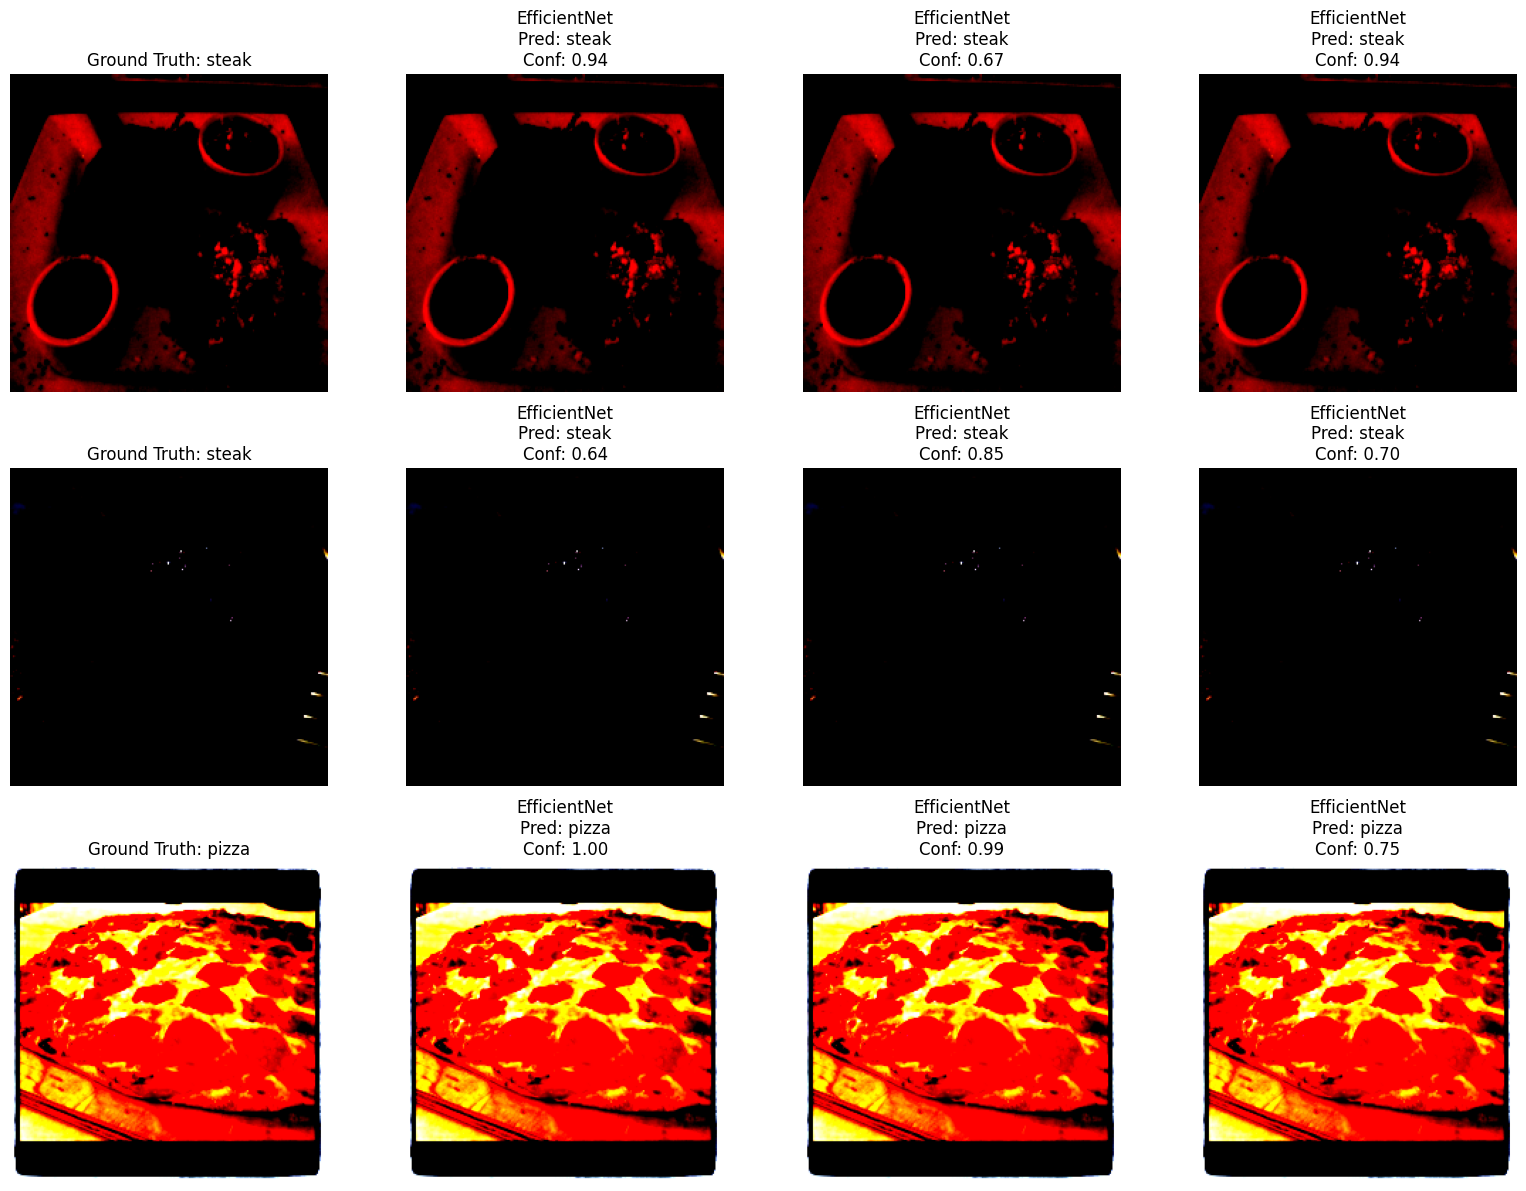

In [11]:
pred_and_plot_random_images(model_list=model_list)

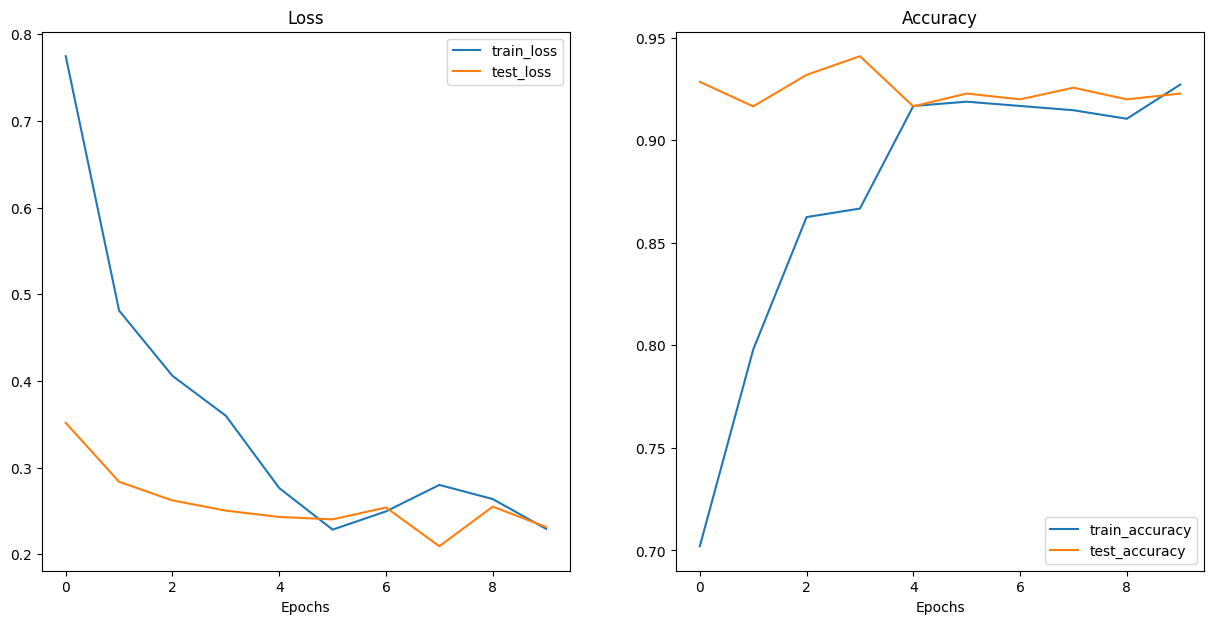

In [13]:
plot_loss_curves(model_b0_results)

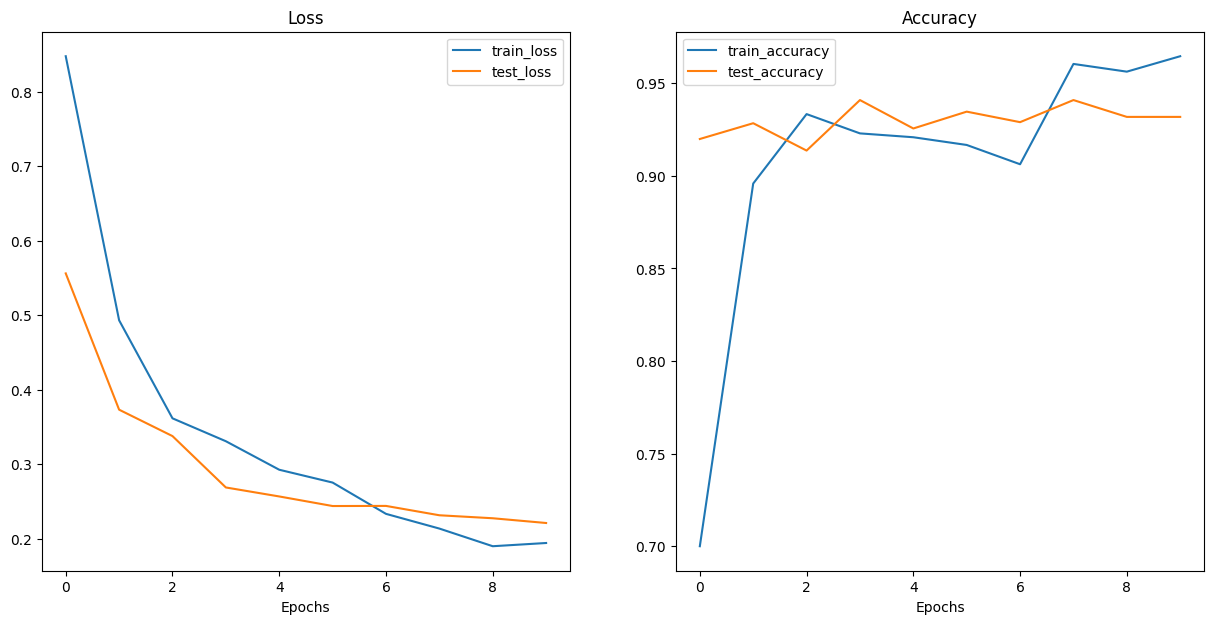

In [14]:
plot_loss_curves(model_b1_results)

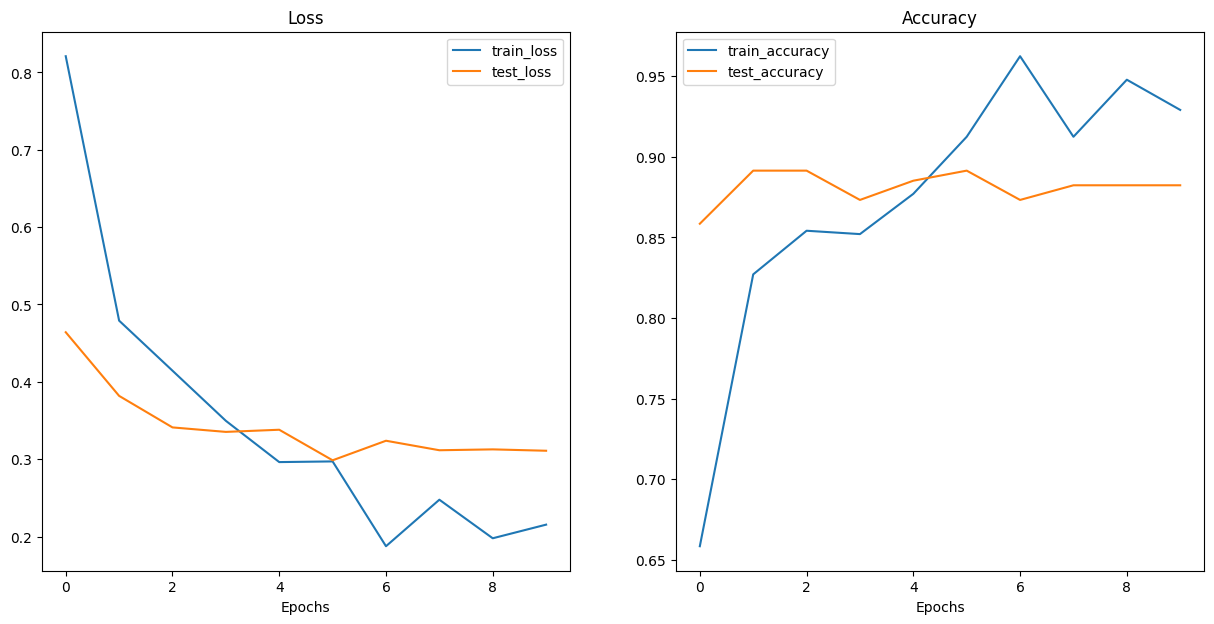

In [15]:
plot_loss_curves(model_b2_results)